
There are two ideas behind this notebook:

- not to use all these min,max,std... features, but instead of it try to find something that can be more interpreteble. I use only 60 features, but i think we can leave half of them without any significant drop. 
- elemenate stock_id from the inputs
- added feature importance for all calculated features



In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/optiver-realized-volatility-prediction/sample_submission.csv
/kaggle/input/optiver-realized-volatility-prediction/train.csv
/kaggle/input/optiver-realized-volatility-prediction/test.csv
/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=97/888f813404d8417ca8d6b8aebd5f2951.parquet
/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=43/bb0efa57f511470e817880842e3e2afa.parquet
/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=21/1d8dc18ebfee47ffbb54b04e6afc0634.parquet
/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=72/60f62a03d8854605901dda072c84db39.parquet
/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=4/761268d671f9429abb29d9d2895e9bd2.parquet
/kaggle/input/optiver-realized-volatility-prediction/trade_train.parquet/stock_id=112/cd283097a5b54293ba400a19e811a7f9.parquet
/kaggle/input/optiver-realized-volatility-pr

In [2]:
#import modules
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import plotly.express as px

import os
import glob

from multiprocessing import Pool

from pandarallel import pandarallel
pandarallel.initialize()

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

import time
import matplotlib.pyplot as plt
%matplotlib inline

path_to_files = "../input/optiver-realized-volatility-prediction"

book_train_files =  path_to_files + '/book_train.parquet/stock_id={}'
trade_train_files =  path_to_files + '/trade_train.parquet/stock_id={}'

book_test_files =  path_to_files + '/book_test.parquet/stock_id={}'
trade_test_files =  path_to_files + '/trade_test.parquet/stock_id={}'

SMALL_F = 0.00000001

tf.random.set_seed(111)
np.random.seed(111)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
#Configuration
cfg = dict(
    isCollectDataOnly = True,
    isStockIdUsed = False,
    isTFModelUsed = False,
    trainNotUsedCols = ['row_id', 'target', 'time_id', 'stock_id'],
    predictNotUsedCols = ['row_id', 'time_id', 'stock_id'],
    useHyperOpt = False,
    useLabelTransformation = False,
    volumeBarThreshold = 500.0
)


cfg

{'isCollectDataOnly': True,
 'isStockIdUsed': False,
 'isTFModelUsed': False,
 'trainNotUsedCols': ['row_id', 'target', 'time_id', 'stock_id'],
 'predictNotUsedCols': ['row_id', 'time_id', 'stock_id'],
 'useHyperOpt': False,
 'useLabelTransformation': False,
 'volumeBarThreshold': 500.0}

## Useful functions

In [4]:
# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

def log_return(prob):
    prob += SMALL_F
    return np.log(prob).diff()

def log_return2(x):
    return np.log1p(x.pct_change())

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))


def getOscStoch(x):
    return (x[-1] - np.min(x))/(np.max(x)-np.min(x)+SMALL_F)

def getNormVal(x):
    return (x[-1])/(np.mean(x)+SMALL_F)

def getBreath(ret, size):
    f = ret > 0
    upside = size[f]
    downside = size[~f]
    
    di = np.sum(upside)/(np.sum(downside)+SMALL_F)
    ado = np.sum(upside) - np.sum(downside)
    
    return di, ado
    
def rateLastFirst(x):
    return np.mean(x)/(np.sum(x)+SMALL_F)

def rolling_windows_vectorized(array, sub_window_size=2):
    start = 0
    max_time = len(array)-sub_window_size
    sub_windows = (
        start +
        # expand_dims are used to convert a 1D array to 2D array.
        np.expand_dims(np.arange(sub_window_size), 0) +
        np.expand_dims(np.arange(max_time + 1), 0).T
    )
    
    return array[sub_windows]

def rolling_windows_vectorized_v2(array, sub_window_size, stride_size):
    start = 0
    max_time = len(array)-sub_window_size
    sub_windows = (
        start + 
        np.expand_dims(np.arange(sub_window_size), 0) +
        # Create a rightmost vector as [0, V, 2V, ...].
        np.expand_dims(np.arange(max_time + 1, step=stride_size), 0).T
    )
    
    return array[sub_windows]    

def getVolumaBars(i_data, threshold=1000.0):
    o, h, l, c, v  = 0.0, 0.0, 1000000.0, 0.0, 0.0
    res_array = []
    isNewBar = True
    bar_index = 0.0
    cum_volume = 0.0
    data_len = i_data.shape[0]
    for i in range(data_len):
        #print(i_data[i])
        cur_price = i_data[i][0]
        #print(cur_price)
        if True == isNewBar:
            bar_index = i
            o = cur_price
            c = 0.0
            h = 0.0
            l = 10000000.0
            v = 0.0
            
            isNewBar = False

        if cur_price > h:
            h = cur_price
        if cur_price < l:
            l = cur_price

        v += i_data[i][1]
        
        if (v >= threshold) or (i == data_len-1):
            isNewBar = True
            #bar_index = i
            c = cur_price
            res_array.append([bar_index, o, h, l, c, v])


    return pd.DataFrame(res_array, columns=['bar_index', 'open', 'high', 'low', 'close', 'volume'])


def _get_beta(high, low, window):

    beta_r = np.empty(high.shape)
    beta_r[:] = np.NaN

    ret = np.log(high / low)
    high_low_ret = ret ** 2
    beta = rolling_windows_vectorized(high_low_ret, 2).sum(axis=1)
    beta = rolling_windows_vectorized(beta, window).mean(axis=1)
    beta_r[len(beta_r)-len(beta):] = beta    

    return beta_r


def _get_gamma(high, low):
    gamma_r = np.empty(high.shape)
    gamma_r[:] = np.NaN

    high_max = rolling_windows_vectorized(high, 2).max(axis=1)
    low_min = rolling_windows_vectorized(low, 2).min(axis=1)
    gamma = np.log(high_max / low_min) ** 2
    gamma_r[len(gamma_r)-len(gamma):] = gamma

    return gamma_r    

def get_bekker_parkinson_vol2(high, low, window: int = 20):

    beta = _get_beta(high, low, window)
    gamma = _get_gamma(high, low)

    k2 = (8 / np.pi) ** 0.5
    den = 3 - 2 * 2 ** .5
    sigma = (2 ** -0.5 - 1) * beta ** 0.5 / (k2 * den)
    sigma += (gamma / (k2 ** 2 * den)) ** 0.5
    sigma[sigma < 0] = 0

    return sigma

def get_garman_class_vol2(open, high, low, close, window):
    ret_value = np.empty(high.shape)
    ret_value[:] = np.NaN
    ret = np.log(high / low)  # High/Low return
    close_open_ret = np.log(close / open)  # Close/Open return
    estimator = 0.5 * ret ** 2 - (2 * np.log(2) - 1) * close_open_ret ** 2
    ret_v = rolling_windows_vectorized(estimator, window).mean(axis=1)
    ret_value[len(ret_value)-len(ret_v):] = np.sqrt(ret_v)
    return ret_value

def getWindows(n_bars, isSpecialWindow=False, min_bar_length=3):
    if(True==isSpecialWindow):
        window_size = n_bars//2
    else:
        window_size = n_bars-(min_bar_length-1)

    if(window_size<=0):
        if(n_bars-1 > 0):
            window_size = n_bars - 1
        else:
            window_size=1

    return window_size

def getMicrostructuralFeatures(input_df, output_df, col_prefix = '', col_postfix = '', min_bar_length = 3, volumeThreshold = cfg['volumeBarThreshold'], isParkinson=True, isGarman=True, isYyang=True, isBekker=True, isMicro=True, isSpecialWindow=False, micro_cols=[]):
    
    v_sum = np.sum(input_df.loc[:, 'size']).astype(np.float64)
    thres = volumeThreshold if v_sum >= volumeThreshold else v_sum
    volume_bars = getVolumaBars(input_df.loc[:,['price','size']].to_numpy(), thres)

    window_size = getWindows(len(volume_bars), isSpecialWindow=isSpecialWindow, min_bar_length=min_bar_length)

    if(True == isGarman):
        col_name = col_prefix+'garman_class_vol'+col_postfix
        pv = get_garman_class_vol2(volume_bars.open.to_numpy(), volume_bars.high.to_numpy(), volume_bars.low.to_numpy(), volume_bars.close.to_numpy(), window=window_size)
        pv = pv[~np.isnan(pv)]
        if(len(pv)>0):
            output_df.loc[:,col_name] = np.median(pv)
        else:
            output_df.loc[:,col_name] = 0.0

    if(True == isBekker):
        col_name = col_prefix+'bekker_parkinson_vol'+col_postfix
        pv = get_bekker_parkinson_vol2(volume_bars.high.to_numpy(), volume_bars.low.to_numpy(), window=window_size)
        pv = pv[~np.isnan(pv)]
        if(len(pv)>0):
            output_df.loc[:,col_name] = np.median(pv)
        else:
            output_df.loc[:,col_name] = 0.0

    return output_df


## Preprocessing book data

In [5]:
def getDataFromBidAsk_numpy(df, ci):
    a = 0
    b = 0
    spread  = {}
    for k in [1,2]:
        #k = i+1
        bidp = 'bid_price{}'.format(k)
        askp = 'ask_price{}'.format(k)
        bids = 'bid_size{}'.format(k)
        asks = 'ask_size{}'.format(k)
        #calculate comulative wap
        a += (df[:,ci[bidp]] * df[:,ci[asks]] + df[:,ci[askp]] * df[:,ci[bids]])
        b += df[:,ci[bids]] + df[:,ci[asks]]

        #wap 1 and 2
        spread[f'fb_w_{k}'] = (df[:,ci[bidp]] * df[:,ci[asks]] + df[:,ci[askp]] * df[:,ci[bids]] ) / (df[:,ci[bids]] + df[:,ci[asks]] + SMALL_F)
        spread[f'fb_mid_point_{k}'] = (df[:,ci[askp]]) + (df[:,ci[bidp]]) / 2
        spread[f'fb_volume_total_{k}'] = (df[:,ci[asks]]) + (df[:,ci[bids]])

    
    # mean wap
    spread['fb_w'] = (a/(b+SMALL_F))
    # rates
    spread['fb_w_rate'] = (spread['fb_w_1']) / (spread['fb_w_2']+SMALL_F) 
    spread['fb_mid_point_rate'] = (spread['fb_mid_point_1']) / (spread['fb_mid_point_2']+SMALL_F)
    #sum volume
    spread['fb_volume_total'] = spread['fb_volume_total_1'] + spread['fb_volume_total_2']

    
    ################# test ##################
    spread['ask_1'] = df[:,ci['ask_price1']]
    spread['bid_1'] = df[:,ci['bid_price1']]
    spread['ask_2'] = df[:,ci['ask_price2']]
    spread['bid_2'] = df[:,ci['bid_price2']]
    #########################################
    
    return spread



def Fx(group, stock_id=0, n=10):
    new_df = pd.DataFrame()
    name = int(group.time_id.unique()[0])
    tmp = pd.DataFrame()

    #calculate log return from the following features:
    cols = [
        'fb_w', 
        'fb_w_1', 
        'fb_w_2',
        'fb_mid_point_1',
        'fb_mid_point_rate',
        'fb_w_rate',
    ]

    new_cols = [s + '_lr' for s in cols]
    group.loc[:,new_cols] = log_return2(group[cols]).to_numpy()
    group = group[~group['fb_w'].isnull()]

    #calculate realized volatility
    cols = new_cols
    new_cols = [s + '_vola' for s in cols]
    tmp = pd.concat([tmp, pd.DataFrame(realized_volatility(group.loc[:,cols]).to_numpy().reshape(1,-1), columns=new_cols)], axis=1)

    #calculate sum of log return
    cols = [
        'fb_w_2_lr',
    ]
    new_cols = [s + '_sum' for s in cols]
    tmp = pd.concat([tmp, pd.DataFrame(np.sum(group.loc[:,cols]).to_numpy().reshape(1,-1), columns=new_cols)], axis=1)

    #calculate sqsum    
    cols = [
        'fb_w_lr', 
        'fb_w_1_lr', 
        'fb_w_2_lr',
        'fb_mid_point_1_lr',
    ]
    new_cols = [s + '_sqsum' for s in cols]
    tmp = pd.concat([tmp, pd.DataFrame(np.sum((group.loc[:,cols])**2).to_numpy().reshape(1,-1), columns=new_cols)], axis=1)
    
    #calculate book length
    tmp.loc[:,'book_length'] = [group.shape[0]]

    #calclulate market microstructural features
    c = '1'
    cols_1 = []
    new_df = pd.DataFrame({'price': group.loc[:,'fb_mid_point_'+c].to_numpy().flatten(), 'size': group.loc[:,'fb_volume_total_'+c].to_numpy().flatten()}).reset_index()
    tmp = getMicrostructuralFeatures(new_df, tmp, col_prefix = 'fb_', col_postfix = '_'+c, micro_cols=cols_1)
    c = '2'
    cols_2 = []  
    new_df = pd.DataFrame({'price': group.loc[:,'fb_mid_point_'+c].to_numpy().flatten(), 'size': group.loc[:,'fb_volume_total_'+c].to_numpy().flatten()}).reset_index()
    tmp = getMicrostructuralFeatures(new_df, tmp, col_prefix = 'fb_', col_postfix = '_'+c, micro_cols=cols_2)
    
    ############ test idea ################
    col_name = "Test_1"
    window_size = getWindows(len(group), isSpecialWindow=False, min_bar_length=3)
    pv = get_bekker_parkinson_vol2(group.ask_1.to_numpy(), group.bid_1.to_numpy(), window=window_size)
    pv = pv[~np.isnan(pv)]
    if(len(pv)>0):
        tmp.loc[:,col_name] = np.median(pv)
    else:
        tmp.loc[:,col_name] = 0.0

    col_name = "Test_2"
    window_size = getWindows(len(group), isSpecialWindow=False, min_bar_length=3)
    pv = get_bekker_parkinson_vol2(group.ask_2.to_numpy(), group.bid_2.to_numpy(), window=window_size)
    pv = pv[~np.isnan(pv)]
    if(len(pv)>0):
        tmp.loc[:,col_name] = np.median(pv)
    else:
        tmp.loc[:,col_name] = 0.0
    #######################################
    
    tmp.loc[:,'row_id'] = str(stock_id) + '-' + str(name)
    tmp.loc[:,'time_id'] = int(name)
    return tmp

def getFeaturesFromBookData(df, stock_id, n=10):
    results = df.groupby(['time_id']).parallel_apply(Fx, stock_id=stock_id, n=n).reset_index(drop=True)
    return results

## Preprocessing trade data

In [6]:
def getDataFromTrade(df):
    log_ret = log_return(df.price).dropna()
    rz_vol = realized_volatility(log_ret)
    
    tmp = pd.DataFrame()

    
    tmp.loc[:,'p_vwap_my'] = [np.sum(df['price'].values*df['size'].values)/(np.sum(df['size'].values+SMALL_F))]
    tmp.loc[:,'p_rz_vol'] = rz_vol
    tmp.loc[:,'p_sqsum'] = np.sum(log_ret**2)
    tmp.loc[:,'p_sum'] = np.sum(log_ret)
    
    tmp.loc[:,'p_lr_rate'] = rateLastFirst(log_ret)
    
    tmp.loc[:,'p_price_count'] = count_unique(df['price'].to_numpy())
    tmp.loc[:,'p_sec_count'] = count_unique(df['seconds_in_bucket'].to_numpy())

    cols_p = []  
    tmp = getMicrostructuralFeatures(df.loc[:, ['price', 'size']], tmp, col_prefix = 'p_', col_postfix = '', isParkinson=False, isGarman=False, isYyang=False, micro_cols=cols_p)

    tmp.loc[:,'p_size_mean'] = np.mean(df['size']) 

    time_id = df.time_id.unique()[0]
    tmp.loc[:,'time_id'] = time_id
    return tmp

def getFeaturesFromTradeData(df):
    return df.groupby(['time_id']).parallel_apply(getDataFromTrade).reset_index(drop=True)

## Constract \[stock_id,time_id\] features


In [7]:
def constructPreprocessedDataFrame(file_path, isTrain):
    stock_id = file_path.split('=')[1]
    df_book_data = pd.read_parquet(file_path)
    if True == isTrain:
        df_trade_data =  pd.read_parquet(trade_train_files.format(stock_id))
    else:
        df_trade_data =  pd.read_parquet(trade_test_files.format(stock_id))

    print('Processing stock id:', stock_id)
    #display(df_book_data.time_id.unique())
    #preprocess book
    a = time.time()
    spread = getDataFromBidAsk_numpy(df_book_data.to_numpy(),{k: v for v, k in enumerate(df_book_data.columns.values)})
    df_book_data = pd.concat([df_book_data,pd.DataFrame(spread)], axis=1)
    df_book_datar = getFeaturesFromBookData(df_book_data, stock_id, 10)
    b = time.time()
    #print(f'preprocess book: {b-a}')
    
    #preprocess trade
    df_trade_datar = getFeaturesFromTradeData(df_trade_data)
    df_book_datar = df_book_datar.merge(df_trade_datar, on = ['time_id'], how = 'left')
    c = time.time()
    #print(f'preprocess trade: {c-b}')

    df_book_datar.loc[:,'stock_id'] = stock_id
    df_book_datar = df_book_datar.fillna(0.0)
    return df_book_datar

def constructBookDataDataFrame(list_file, isTrain=True):
    df_book = pd.DataFrame()
    for file in list_file:
        df_book = pd.concat([df_book, constructPreprocessedDataFrame(file, isTrain=isTrain)])
    return df_book

## collect and preprocess data

In [8]:
list_order_book_file_train = glob.glob(path_to_files + '/book_train.parquet/*')
list_order_book_file_train[0:1]

['../input/optiver-realized-volatility-prediction/book_train.parquet/stock_id=97']

In [9]:
%%time
ret_df = constructBookDataDataFrame(list_order_book_file_train)
display(ret_df.shape)
ret_df.head()

Processing stock id: 97
Processing stock id: 43
Processing stock id: 21
Processing stock id: 72
Processing stock id: 4
Processing stock id: 112
Processing stock id: 22
Processing stock id: 105
Processing stock id: 116
Processing stock id: 63
Processing stock id: 14
Processing stock id: 87
Processing stock id: 122
Processing stock id: 59
Processing stock id: 113
Processing stock id: 23
Processing stock id: 38
Processing stock id: 76
Processing stock id: 125
Processing stock id: 15
Processing stock id: 67
Processing stock id: 27
Processing stock id: 30
Processing stock id: 1
Processing stock id: 66
Processing stock id: 96
Processing stock id: 9
Processing stock id: 13
Processing stock id: 18
Processing stock id: 50
Processing stock id: 32
Processing stock id: 95
Processing stock id: 110
Processing stock id: 101
Processing stock id: 114
Processing stock id: 98
Processing stock id: 118
Processing stock id: 82
Processing stock id: 19
Processing stock id: 5
Processing stock id: 70
Processing

(428932, 30)

CPU times: user 34min 41s, sys: 2min 19s, total: 37min 1s
Wall time: 2h 29min 16s


,fb_w_lr_vola,fb_w_1_lr_vola,fb_w_2_lr_vola,fb_mid_point_1_lr_vola,fb_mid_point_rate_lr_vola,fb_w_rate_lr_vola,fb_w_2_lr_sum,fb_w_lr_sqsum,fb_w_1_lr_sqsum,fb_w_2_lr_sqsum,...,p_vwap_my,p_rz_vol,p_sqsum,p_sum,p_lr_rate,p_price_count,p_sec_count,p_bekker_parkinson_vol,p_size_mean,stock_id
0,0.007990,0.007263,0.012585,0.004580,0.003170,0.012925,-0.002515,0.000064,0.000053,0.000158,...,1.001467,0.004278,0.000018,-0.002733,0.026316,36.0,39.0,0.001903,101.820513,97
1,0.002823,0.002919,0.005377,0.001593,0.001522,0.006754,-0.001442,0.000008,0.000009,0.000029,...,0.999347,0.001639,0.000003,-0.002021,0.041667,24.0,25.0,0.001231,77.760000,97
2,0.003888,0.003799,0.006038,0.002644,0.002192,0.006469,-0.001723,0.000015,0.000014,0.000036,...,0.999569,0.002517,0.000006,-0.001669,0.019608,36.0,52.0,0.001006,102.615385,97
3,0.004224,0.003753,0.007352,0.002550,0.002072,0.008663,0.000393,0.000018,0.000014,0.000054,...,0.999628,0.002241,0.000005,0.000541,0.039999,25.0,26.0,0.000000,164.730769,97
4,0.004029,0.004365,0.006709,0.002792,0.002521,0.007886,-0.001718,0.000016,0.000019,0.000045,...,0.998940,0.002836,0.000008,-0.000651,0.055556,19.0,19.0,0.001063,153.631579,97


## construct features across dataset

In [10]:
%%time
def getDataFromTransformedDataFx(df, prefix=''):
    cs = ['row_id', 'stock_id', 'time_id']
    used_cols = list(set(df.columns.to_list()) - set(cs))
    for c in used_cols:
        df.loc[:, prefix+c+'_rate'] = df.loc[:,c] / (np.mean(df.loc[:,c]) + SMALL_F)
        df.loc[:, prefix+c+'_diff'] = df.loc[:,c] - (np.mean(df.loc[:,c]) )

    return df

def getDataFromTransformedData(df):
    tmp1 = df.groupby(['stock_id']).parallel_apply(getDataFromTransformedDataFx, prefix='stock_id_').reset_index(drop=True)
    cols_tmp1 = [x for x in tmp1.columns if 'stock_id_' in x]
    cols_tmp1.append('stock_id')
    cols_tmp1.append('time_id')
    tmp2 = df.groupby(['time_id']).parallel_apply(getDataFromTransformedDataFx, prefix='time_id_').reset_index(drop=True)
    cols_tmp2 = [x for x in tmp2.columns if 'time_id_' in x]
    cols_tmp2.append('stock_id')
    cols_tmp2.append('time_id')

    df = df.merge(tmp1.loc[:,cols_tmp1], on = ['stock_id', 'time_id'], how = 'left')
    df = df.merge(tmp2.loc[:,cols_tmp2], on = ['stock_id', 'time_id'], how = 'left')
    
    print(df.shape)

    return df

ret_df = getDataFromTransformedData(ret_df)
ret_df.head()

(428932, 138)
CPU times: user 12min 37s, sys: 12min 23s, total: 25min 1s
Wall time: 26min 36s


,fb_w_lr_vola,fb_w_1_lr_vola,fb_w_2_lr_vola,fb_mid_point_1_lr_vola,fb_mid_point_rate_lr_vola,fb_w_rate_lr_vola,fb_w_2_lr_sum,fb_w_lr_sqsum,fb_w_1_lr_sqsum,fb_w_2_lr_sqsum,...,time_id_fb_mid_point_rate_lr_vola_rate,time_id_fb_mid_point_rate_lr_vola_diff,time_id_fb_garman_class_vol_1_rate,time_id_fb_garman_class_vol_1_diff,time_id_p_sum_rate,time_id_p_sum_diff,time_id_p_vwap_my_rate,time_id_p_vwap_my_diff,time_id_fb_w_1_lr_sqsum_rate,time_id_fb_w_1_lr_sqsum_diff
0,0.007990,0.007263,0.012585,0.004580,0.003170,0.012925,-0.002515,0.000064,0.000053,0.000158,...,2.474639,0.001889,1.718040,0.000063,-3.604971,-0.003492,0.999132,-0.000870,2.049133,0.000027
1,0.002823,0.002919,0.005377,0.001593,0.001522,0.006754,-0.001442,0.000008,0.000009,0.000029,...,2.085174,0.000792,1.601261,0.000026,-5.060555,-0.002420,0.998831,-0.001169,1.304576,0.000002
2,0.003888,0.003799,0.006038,0.002644,0.002192,0.006469,-0.001723,0.000015,0.000014,0.000036,...,3.115769,0.001489,2.811638,0.000070,4.826595,-0.001323,0.999894,-0.000106,2.491590,0.000009
3,0.004224,0.003753,0.007352,0.002550,0.002072,0.008663,0.000393,0.000018,0.000014,0.000054,...,2.582446,0.001270,1.391833,0.000022,-1.716719,0.000856,0.999944,-0.000056,1.691209,0.000006
4,0.004029,0.004365,0.006709,0.002792,0.002521,0.007886,-0.001718,0.000016,0.000019,0.000045,...,3.703251,0.001840,2.067543,0.000045,12.814692,-0.000600,1.008262,0.008186,3.763334,0.000014


In [11]:
cs = ['Unnamed: 0', 'row_id', 'stock_id', 'time_id']
used_cols = list(set(ret_df.columns.to_list()) - set(cs))
y_col = 'target'

ALL_STOCKS = {k: v for v, k in enumerate(ret_df.stock_id.unique())}

In [12]:
_used_cols = ['fb_w_1_lr_sqsum',
 'fb_w_1_lr_vola',
 'fb_w_2_lr_sqsum',
 'p_rz_vol',
 'fb_w_lr_vola',
 'fb_bekker_parkinson_vol_2',
 'fb_w_2_lr_vola',
 'time_id_p_lr_rate_diff',
 'fb_bekker_parkinson_vol_1',
 'time_id_p_sec_count_diff',
 'book_length',
 'time_id_fb_bekker_parkinson_vol_1_diff',
 'p_price_count',
 'stock_id_fb_w_1_lr_vola_rate',
 'time_id_fb_bekker_parkinson_vol_2_diff',
 'stock_id_book_length_diff',
 'fb_w_rate_lr_vola',
 'p_sqsum',
 'p_lr_rate',
 'p_bekker_parkinson_vol',
 'p_sec_count',
 #'time_id_fb_avg_tick_size_2_diff',
 'stock_id_fb_w_1_lr_vola_diff',
 'stock_id_p_sqsum_diff',
 'time_id_fb_w_1_lr_vola_rate',
 'stock_id_fb_w_rate_lr_vola_rate',
 'time_id_fb_bekker_parkinson_vol_1_rate',
 'time_id_p_sqsum_diff',
 'time_id_book_length_rate',
 'time_id_book_length_diff',
 'time_id_fb_bekker_parkinson_vol_2_rate',
 'time_id_p_bekker_parkinson_vol_diff',
 'fb_garman_class_vol_1',
 'fb_mid_point_rate_lr_vola',
'time_id_p_lr_rate_rate',
 'stock_id_fb_w_lr_vola_rate',
 'stock_id_fb_mid_point_1_lr_sqsum_diff',
 'time_id_fb_w_1_lr_vola_diff',
 'stock_id_fb_bekker_parkinson_vol_2_diff',
 'stock_id_fb_mid_point_rate_lr_vola_diff',
 'time_id_fb_w_lr_vola_diff',
 'stock_id_fb_mid_point_1_lr_vola_diff',
 'stock_id_fb_bekker_parkinson_vol_1_diff',
 'stock_id_fb_w_2_lr_sum_diff',
 'time_id_fb_w_lr_sqsum_rate',
 'stock_id_fb_mid_point_1_lr_vola_rate',
 'stock_id_fb_garman_class_vol_1_rate',
 #'time_id_fb_avg_tick_size_1_diff',
 'stock_id_fb_w_rate_lr_vola_diff',
 'time_id_fb_garman_class_vol_2_diff',
 'stock_id_fb_w_lr_vola_diff',
 'stock_id_fb_mid_point_rate_lr_vola_rate',
             
 ###########################################
 'stock_id_Test_1_diff',
 'stock_id_Test_1_rate',
 'Test_1',
 'time_id_Test_1_diff',
 'time_id_Test_1_rate',
 'stock_id_Test_2_diff',
 'stock_id_Test_2_rate',
 'Test_2',
 'time_id_Test_2_diff',
 'time_id_Test_2_rate'
##########################################             
 ]

In [13]:
#list(set(used_cols2) - set(used_cols))

In [14]:
ret_df.loc[:, used_cols].head()

,fb_w_1_lr_vola,fb_garman_class_vol_2,stock_id_fb_w_1_lr_sqsum_diff,time_id_fb_w_1_lr_sqsum_rate,time_id_p_sec_count_rate,time_id_p_rz_vol_rate,fb_w_2_lr_vola,stock_id_fb_w_1_lr_sqsum_rate,time_id_fb_w_1_lr_sqsum_diff,time_id_p_sum_rate,...,p_size_mean,stock_id_fb_garman_class_vol_1_rate,p_sec_count,stock_id_Test_1_diff,stock_id_fb_w_2_lr_vola_diff,fb_mid_point_1_lr_vola,stock_id_p_vwap_my_rate,stock_id_fb_garman_class_vol_2_rate,fb_garman_class_vol_1,time_id_fb_garman_class_vol_1_diff
0,0.007263,0.000234,-0.000016,2.049133,0.367337,1.598897,0.012585,0.762648,0.000027,-3.604971,...,101.820513,0.984438,39.0,0.000094,0.002101,0.004580,1.001492,1.085002,0.000150,0.000063
1,0.002919,0.000098,-0.000061,1.304576,0.479698,1.231736,0.005377,0.123186,0.000002,-5.060555,...,77.760000,0.450718,25.0,-0.000254,-0.005108,0.001593,0.999372,0.455673,0.000069,0.000026
2,0.003799,0.000110,-0.000055,2.491590,0.799890,1.633031,0.006038,0.208601,0.000009,4.826595,...,102.615385,0.710071,52.0,-0.000274,-0.004447,0.002644,0.999594,0.510287,0.000108,0.000070
3,0.003753,0.000123,-0.000055,1.691209,0.535097,1.436274,0.007352,0.203663,0.000006,-1.716719,...,164.730769,0.503461,26.0,-0.000274,-0.003133,0.002550,0.999653,0.569324,0.000077,0.000022
4,0.004365,0.000131,-0.000050,3.763334,0.404871,2.341371,0.006709,0.275452,0.000014,12.814692,...,153.631579,0.574601,19.0,0.000175,-0.003775,0.002792,0.998965,0.607403,0.000088,0.000045


## Model Definition

In [15]:
train = pd.read_csv(path_to_files + '/train.csv')
train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [16]:
scaler_target = MinMaxScaler()
def getTrainData(ret_df, seed = 42):
    train = pd.read_csv(path_to_files + '/train.csv')
    #convert stock_id to the same time as in train data
    ret_df.stock_id = ret_df.stock_id.astype(int)
    #merge
    data_df = ret_df.merge(train, on = ['stock_id', 'time_id'], how = 'left')
    data_df.loc[:,'target_orig'] = data_df.loc[:,'target'] 

    if True == cfg['useLabelTransformation']:
        data_df.loc[:,'target'] = data_df.loc[:,'target'] * 100
        scaler_target.fit(data_df.loc[:,'target'].to_numpy().reshape(-1,1))
        data_df.loc[:,'target'] = scaler_target.transform(data_df.loc[:,'target'].to_numpy().reshape(-1,1)).flatten()

    #get train test index 
    all_time_ids = data_df.time_id.unique()

    train_ids, val_ids = train_test_split(all_time_ids, test_size=0.05, random_state=seed)
    test_ids, val_ids = train_test_split(val_ids, test_size=0.5, random_state=seed)

    f = data_df.time_id.isin(train_ids)
    train_df = data_df.loc[f].reset_index(drop=True)

    f = data_df.time_id.isin(val_ids)
    val_df = data_df.loc[f].reset_index(drop=True)

    f = data_df.time_id.isin(test_ids)
    test_df = data_df.loc[f].reset_index(drop=True)    
    
    return train_df, val_df, test_df

def predictFromModel(model, df, used_cols=used_cols, prediction_column_name='target'):
    predict = model.predict(df.loc[:, used_cols].values).flatten()
    df_ret = pd.DataFrame()
    df_ret[prediction_column_name] = predict
    df_ret['row_id'] = df['row_id'].values
    return df_ret[['row_id', prediction_column_name]].reset_index(drop=True)

In [17]:
from sklearn.model_selection import train_test_split
import lightgbm as lgbm

def feval_RMSPE(preds, train_data):
    labels = train_data.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False

def printAndReturnModelDescrAndErrors(model, model_id, y_test, predict_y):
    R2 = round(r2_score(y_true = y_test, y_pred = predict_y),5)
    RMSPE = round(rmspe(y_true = y_test, y_pred = predict_y),5)
    print(f'Model {model_id} Performance of the prediction: R2 score: {R2}, RMSPE: {RMSPE}')
    
    return  {'model':model, 'R2':R2, 'RMSPE':RMSPE}

def getTrainDats(df, df_target, test_size):
    df_target['row_id'] = df_target['stock_id'].astype(str) + '-' + df_target['time_id'].astype(str)
    df_joined = df.merge(df_target[['row_id','target']], on = ['row_id'], how = 'left')
    
    cols_no_used = cfg['trainNotUsedCols']
    
    X_train, X_test, y_train, y_test = train_test_split(df_joined.loc[:, ~df_joined.columns.isin(cols_no_used)], 
                                                        df_joined.target,
                                                        test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

def train_model_lgbm(df_train, df_val, df_test, X_col, y_col, cat_feats, model_id):
    
    for c in cat_feats:
        df_train[c] = df_train[c].astype(int)
        df_val[c] = df_val[c].astype(int)
        df_test[c] = df_test[c].astype(int)
    #print(X_train.columns)
    train = lgbm.Dataset(df_train.loc[:,X_col], label=df_train.loc[:,y_col], categorical_feature=cat_feats, weight=1/np.power(df_train.loc[:,y_col],2))
    val = lgbm.Dataset(df_val.loc[:,X_col], label=df_val.loc[:,y_col], categorical_feature=cat_feats, weight=1/np.power(df_val.loc[:,y_col],2))
    test = lgbm.Dataset(df_test.loc[:,X_col], label=df_test.loc[:,y_col], categorical_feature=cat_feats, weight=1/np.power(df_test.loc[:,y_col],2))
    

    lgbm_params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'learning_rate': 0.15, #0.01,
        'objective': 'regression',
        'metric': 'None',
        'max_depth': -1,
        'n_jobs': -1,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.75,
         'lambda_l1': 1, # L1 regularization
         'lambda_l2': 1, # L2 Regularization
         'bagging_seed': 100, # random seed, default in light 100
        
    }

    model = lgbm.train(lgbm_params, 
                          train, 
                          50000, 
                          valid_sets=test, 
                          feval=feval_RMSPE,
                          early_stopping_rounds=1500,
                          verbose_eval=False,
                          categorical_feature=cat_feats,
                         )

    predict_y = model.predict(df_test.loc[:,X_col])
    
    model_descr = printAndReturnModelDescrAndErrors(model, model_id, df_test.loc[:,y_col], predict_y)

    return model_descr


## Train Models

In [18]:
def trainModel(df, n_models=1, seeds=[]):
    models_stat = {}
    for i in range(n_models):
        if len(seeds) == 0:
            rnd_seed = np.random.randint(1000)
        else:
            rnd_seed = seeds[i]
        
        train_df, val_df, test_df = getTrainData(ret_df, seed=rnd_seed)
        used_cols_lgbm = used_cols.copy()
        #used_cols_lgbm.append('stock_id')
        models_stat['model'+str(i)] = train_model_lgbm(train_df, val_df, test_df, used_cols_lgbm, 'target_orig', [], "lgbm_model"+str(i))
    return models_stat

In [19]:
models = trainModel(ret_df, n_models=5, seeds=[42,456,555,333,444])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.362755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34415
[LightGBM] [Info] Number of data points in the train set: 407428, number of used features: 135
[LightGBM] [Info] Start training from score 0.001807
Model lgbm_model0 Performance of the prediction: R2 score: 0.78872, RMSPE: 0.21205
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.379259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 34415
[LightGBM] [Info] Number of data points in the train set: 407428, number of used features: 135
[LightGBM] [Info] Start training from score 0.001804
Model lgbm_model1 Performance of the prediction: R2 score: 0.7835, RMSPE: 0.23044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.377240 seconds.
You can set `force_col_wise=true

In [20]:
def predictFromModels(models_stat, df, used_cols=used_cols, weight=[]):
    predictions = None
    if(len(models_stat.keys()) == 1):
        predictions = predictFromModel(models_stat['model0']['model'], df)
    else:
        isFirst=True
        w = 1/len(models_stat.keys())
        for k in models_stat.keys():
            if(isFirst==True):
                isFirst=False
                predictions = predictFromModel(models_stat[k]['model'], df)
                predictions.loc[:,'target'] = predictions.loc[:,'target'] * w
            else:
                p = predictFromModel(models_stat[k]['model'], df).loc[:, 'target']
                predictions.loc[:,'target'] += p * w
                
    return predictions

## Test Prediction

In [21]:
train_df, val_df, test_df = getTrainData(ret_df, seed=777)
tt = predictFromModels(models, test_df)
predict_y = tt.loc[:,'target']
test_y = test_df.loc[:,y_col]
_ = printAndReturnModelDescrAndErrors(None, "lgbms", test_y, predict_y)

Model lgbms Performance of the prediction: R2 score: 0.82259, RMSPE: 0.21204


## Prepare test data

In [22]:
list_order_book_file_train = glob.glob(path_to_files + '/book_test.parquet/*')
list_order_book_file_train

['../input/optiver-realized-volatility-prediction/book_test.parquet/stock_id=0']

In [23]:
%%time
t_df = constructBookDataDataFrame(list_order_book_file_train, isTrain=False)
t_df = getDataFromTransformedData(t_df)
display(t_df.shape)
t_df.head()

Processing stock id: 0
(1, 138)


(1, 138)

CPU times: user 115 ms, sys: 247 ms, total: 362 ms
Wall time: 706 ms


,fb_w_lr_vola,fb_w_1_lr_vola,fb_w_2_lr_vola,fb_mid_point_1_lr_vola,fb_mid_point_rate_lr_vola,fb_w_rate_lr_vola,fb_w_2_lr_sum,fb_w_lr_sqsum,fb_w_1_lr_sqsum,fb_w_2_lr_sqsum,...,time_id_fb_mid_point_rate_lr_vola_rate,time_id_fb_mid_point_rate_lr_vola_diff,time_id_fb_garman_class_vol_1_rate,time_id_fb_garman_class_vol_1_diff,time_id_p_sum_rate,time_id_p_sum_diff,time_id_p_vwap_my_rate,time_id_p_vwap_my_diff,time_id_fb_w_1_lr_sqsum_rate,time_id_fb_w_1_lr_sqsum_diff
0,0.000263,0.000294,0.000252,0.000033,0.000131,0.000051,0.000277,6.935687e-08,8.655288e-08,6.350246e-08,...,0.999924,0.0,0.999097,0.0,1.000035,0.0,1.0,0.0,0.89643,0.0


## Predict test

In [24]:
tmp = predictFromModels(models, t_df)

tmp.to_csv('submission.csv',index = False)
tmp.head()

,row_id,target
0,0-4,0.000038


## Feature Importance

model0 - R2: 0.78872 RMSPE: 0.21205
model1 - R2: 0.7835 RMSPE: 0.23044
model2 - R2: 0.81801 RMSPE: 0.23545
model3 - R2: 0.81753 RMSPE: 0.22058
model4 - R2: 0.74516 RMSPE: 0.22372


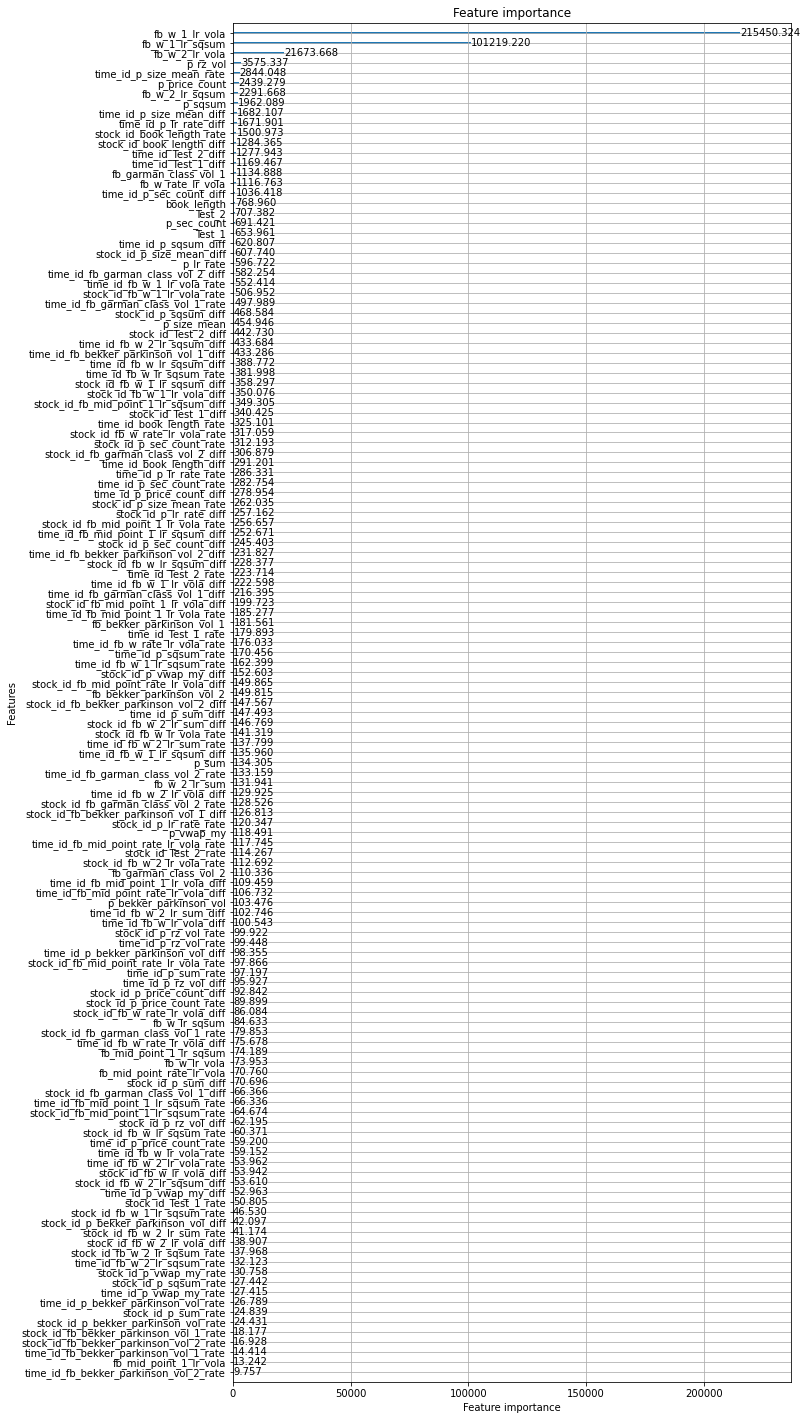

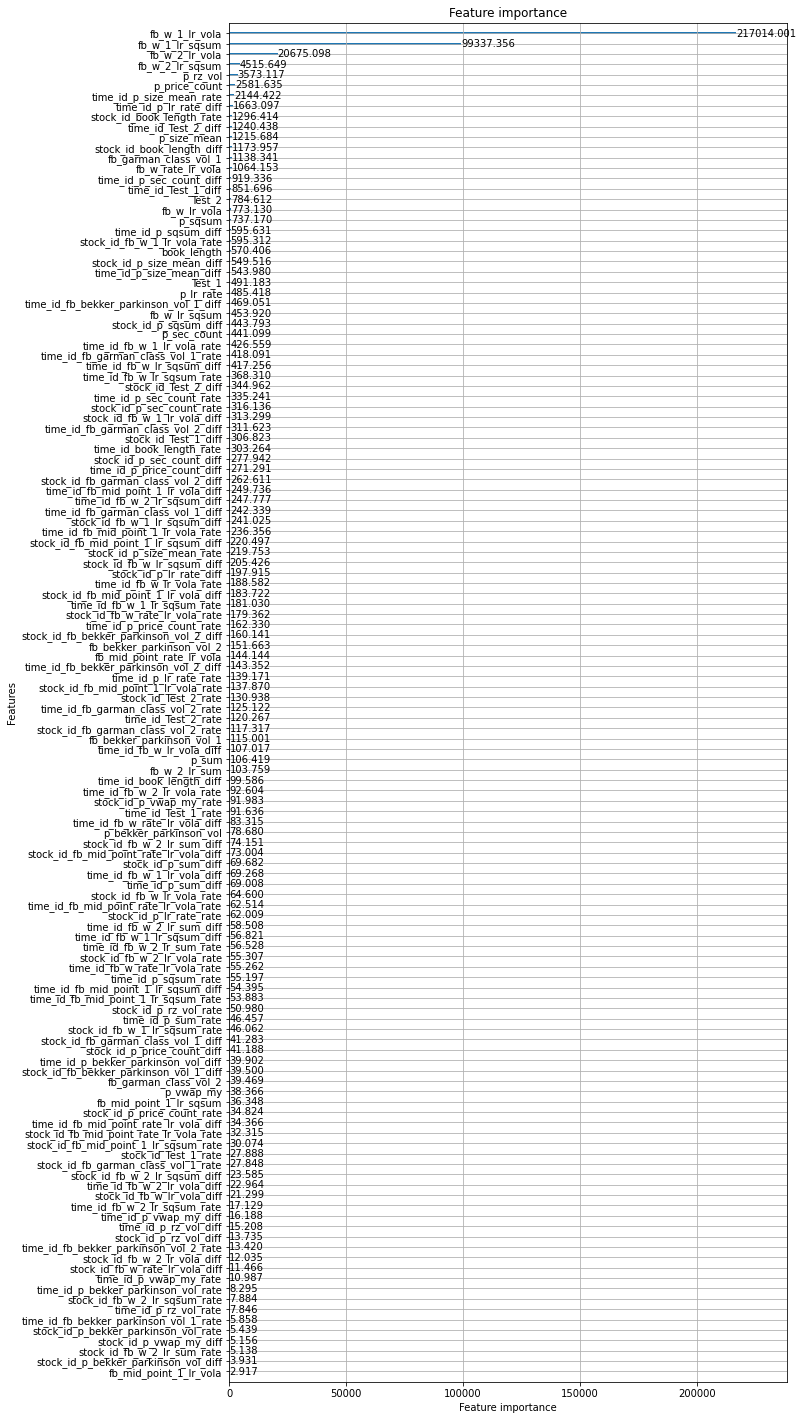

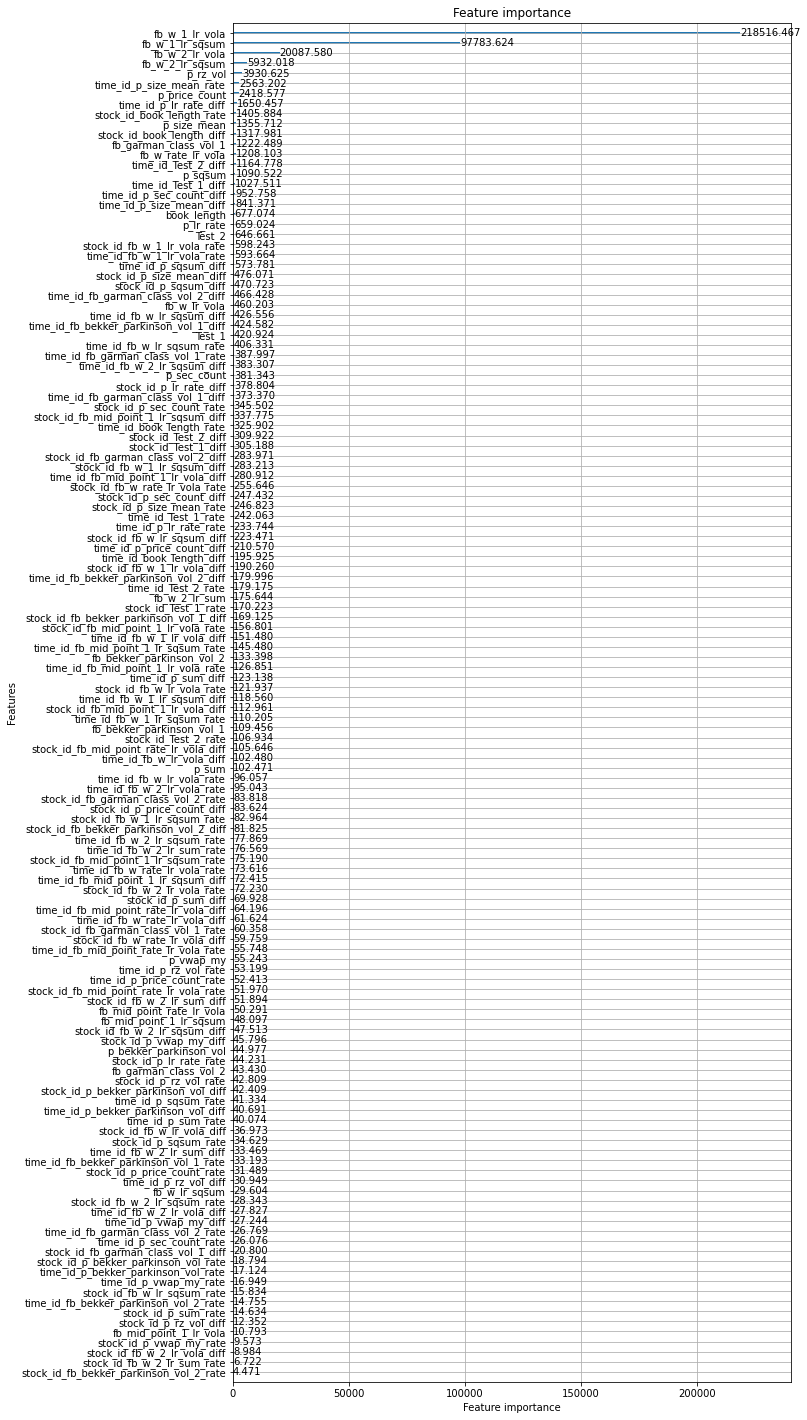

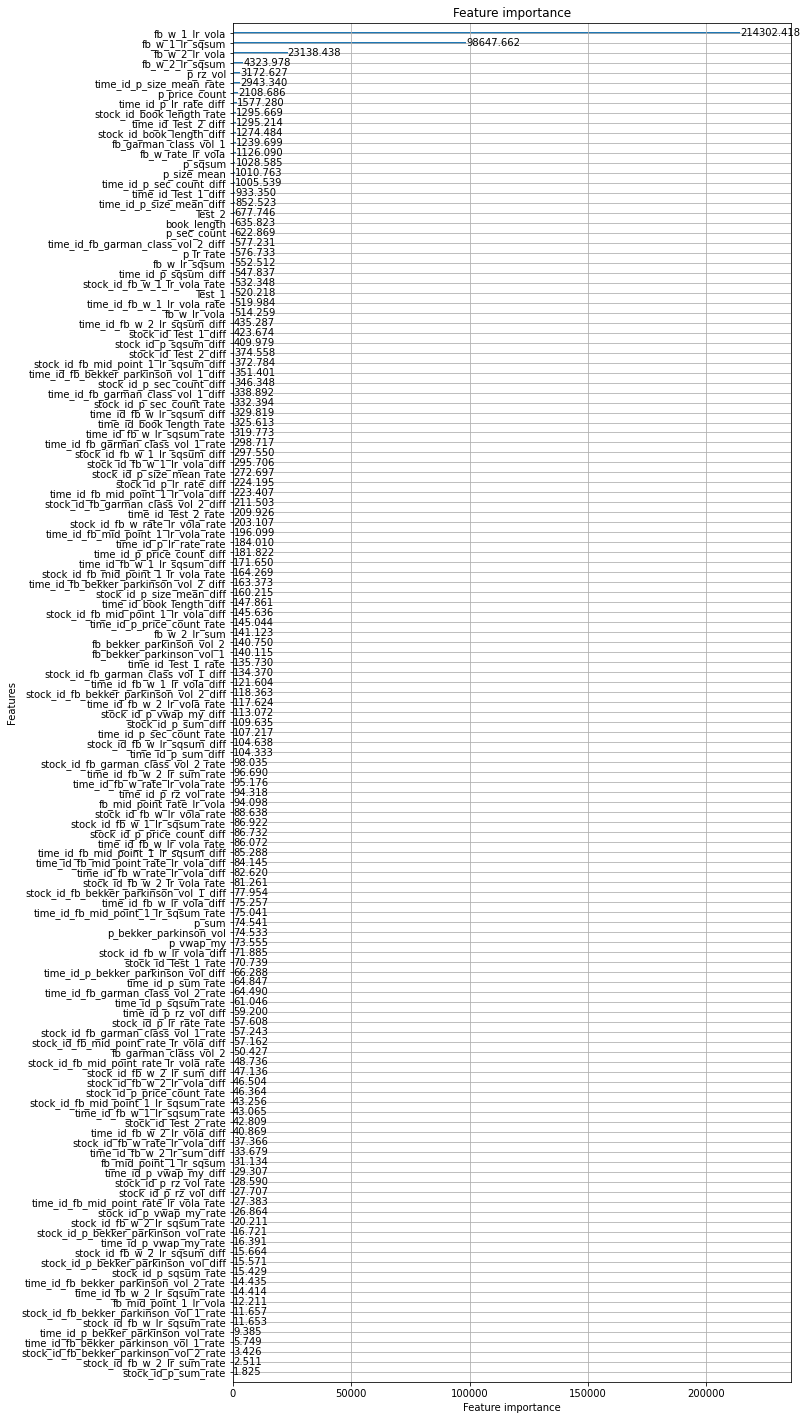

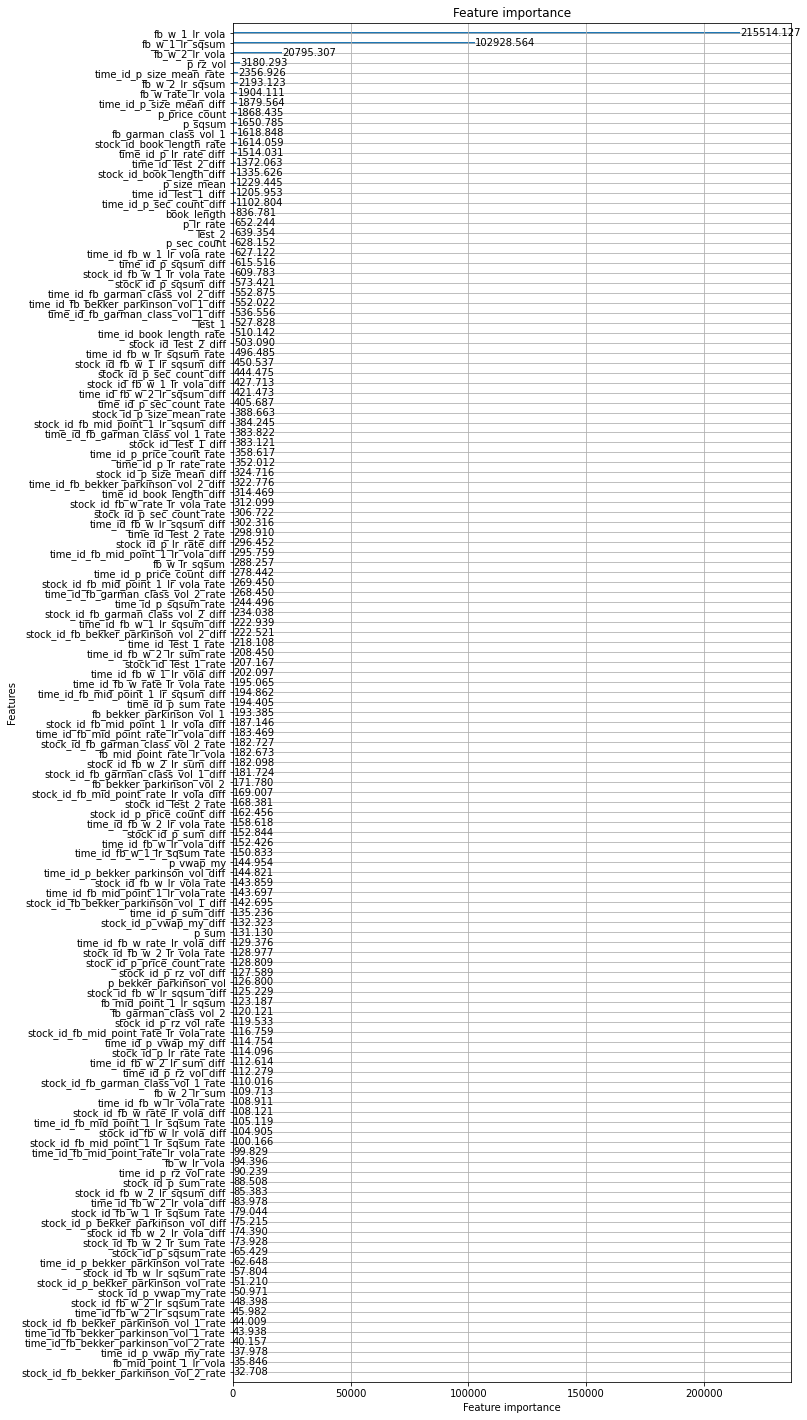

In [25]:
#models
for k,v in models.items():
    print(f"{k} - R2: {v['R2']} RMSPE: {v['RMSPE']}")
    lgbm.plot_importance(v['model'], figsize=(10,25), importance_type='gain')

model0 - R2: 0.78872 RMSPE: 0.21205
model1 - R2: 0.7835 RMSPE: 0.23044
model2 - R2: 0.81801 RMSPE: 0.23545
model3 - R2: 0.81753 RMSPE: 0.22058
model4 - R2: 0.74516 RMSPE: 0.22372


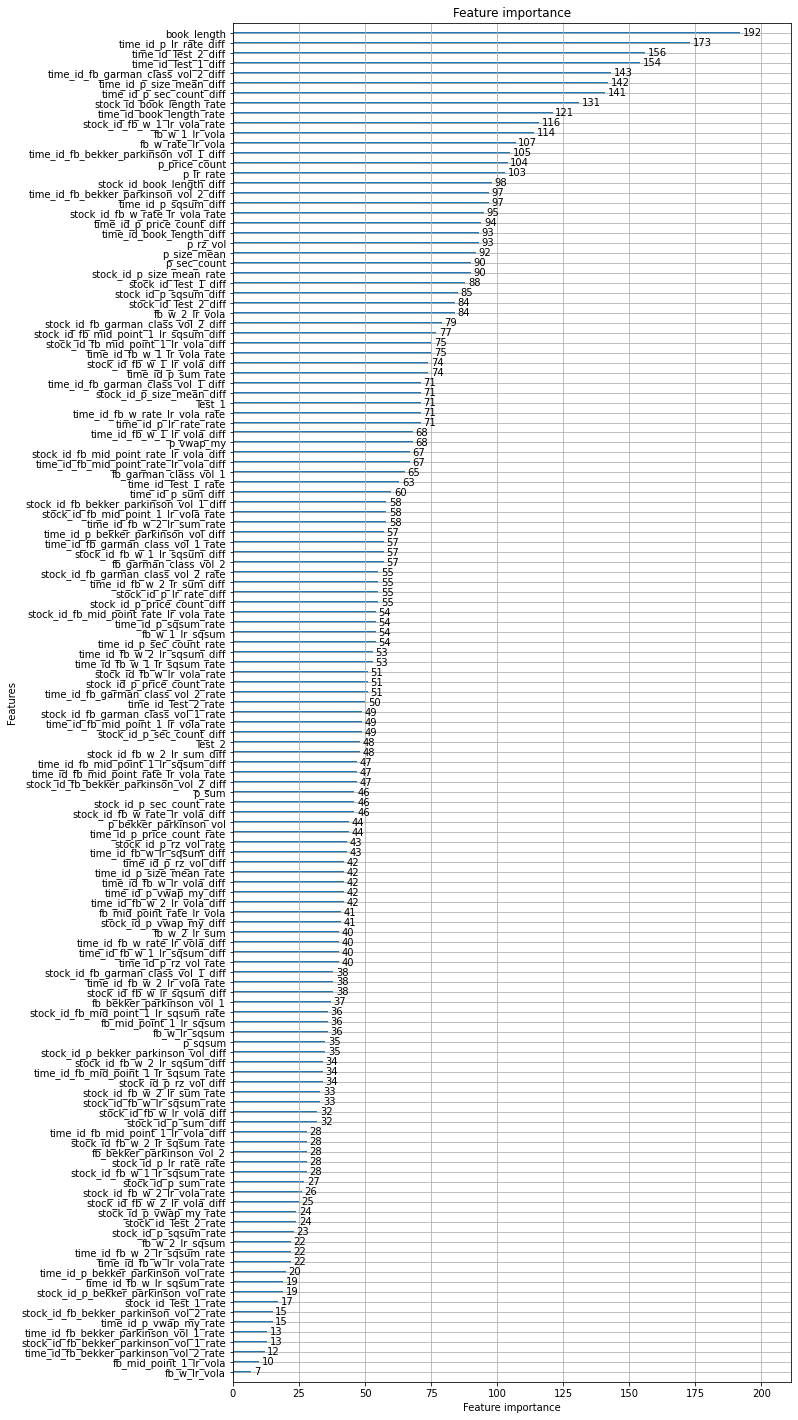

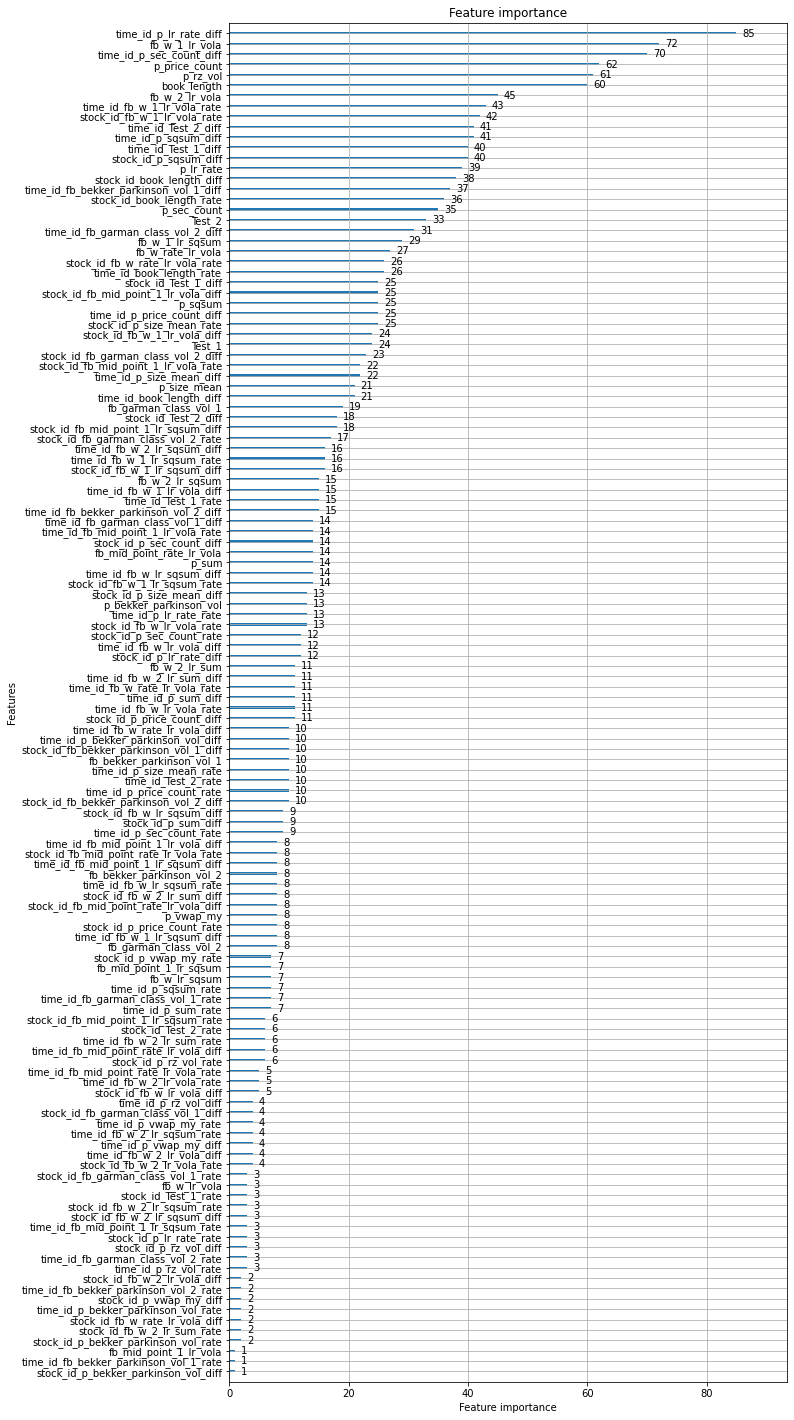

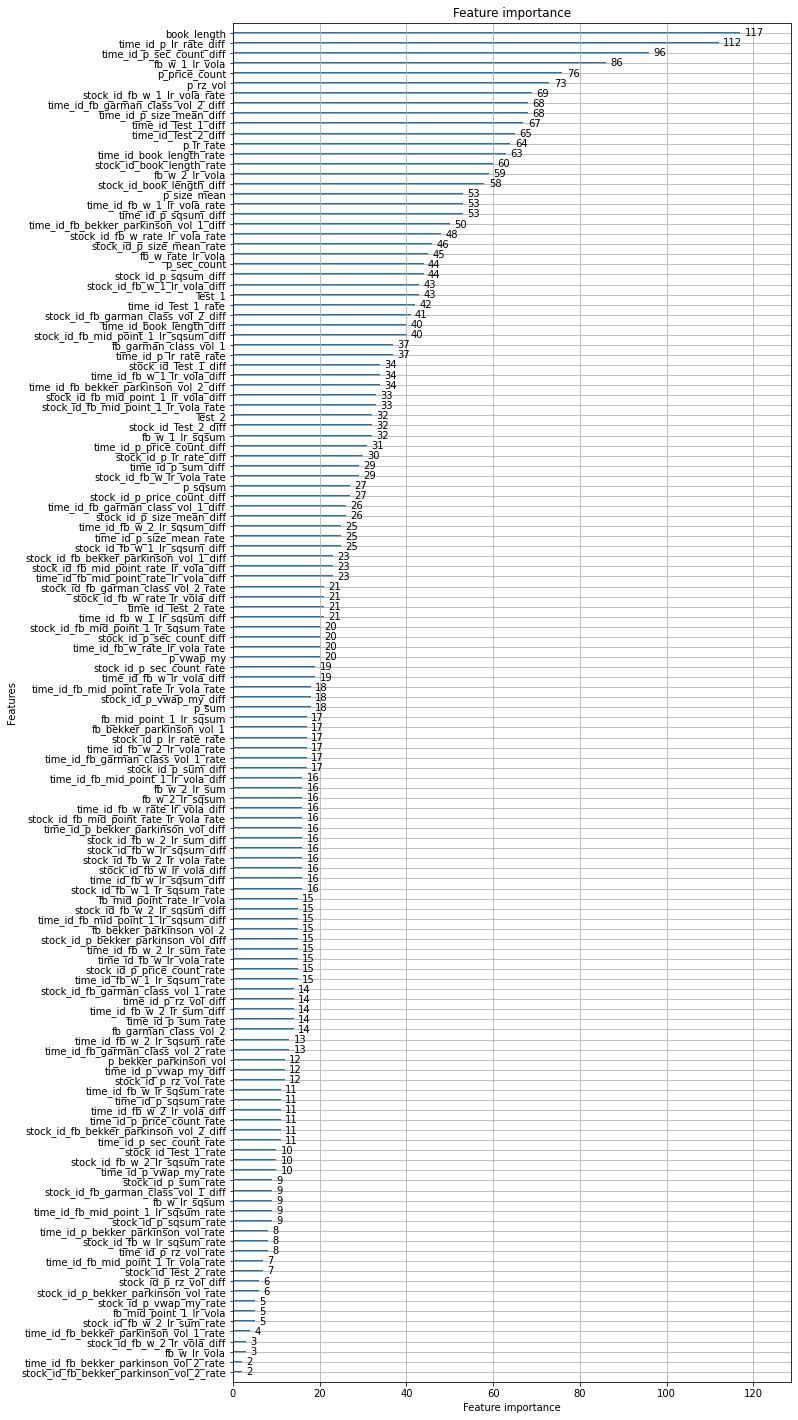

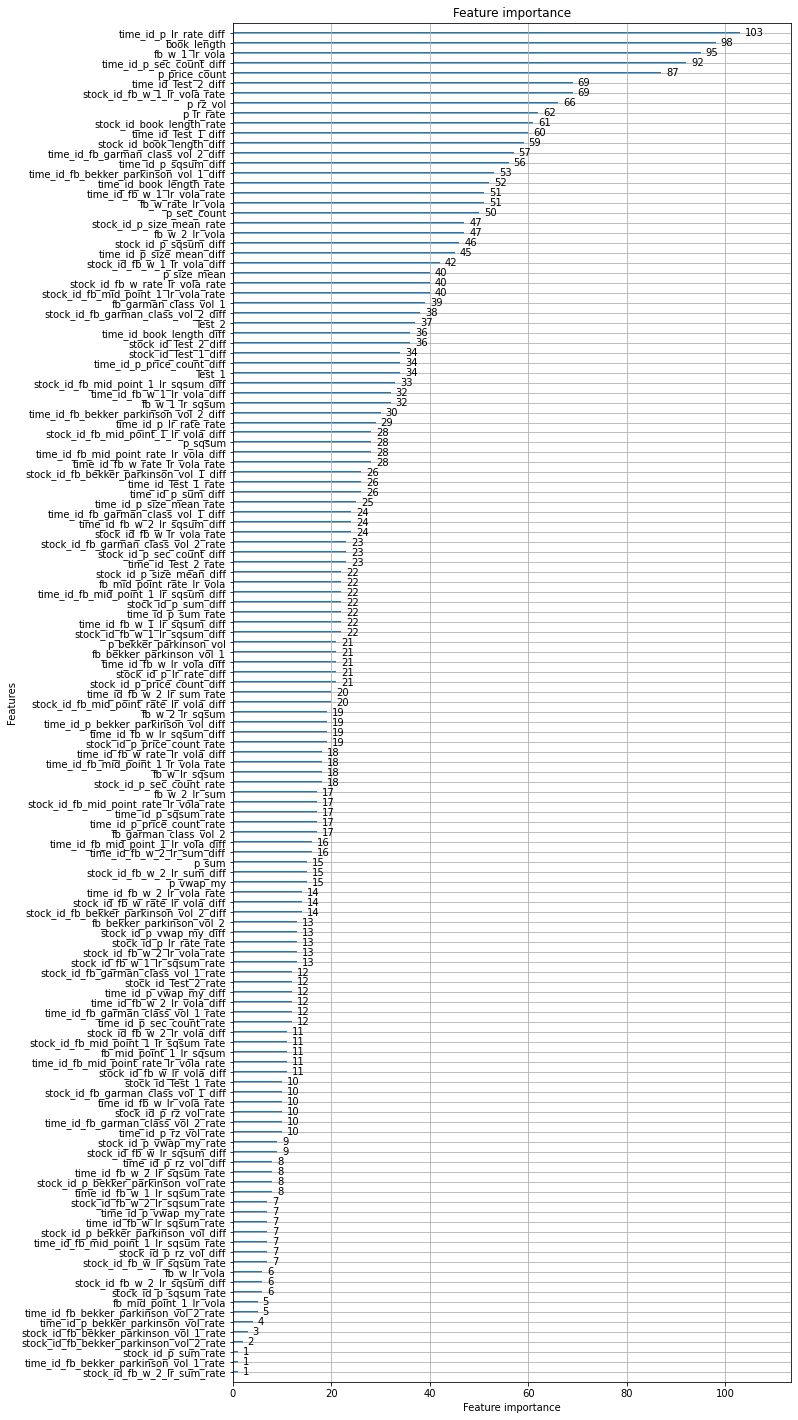

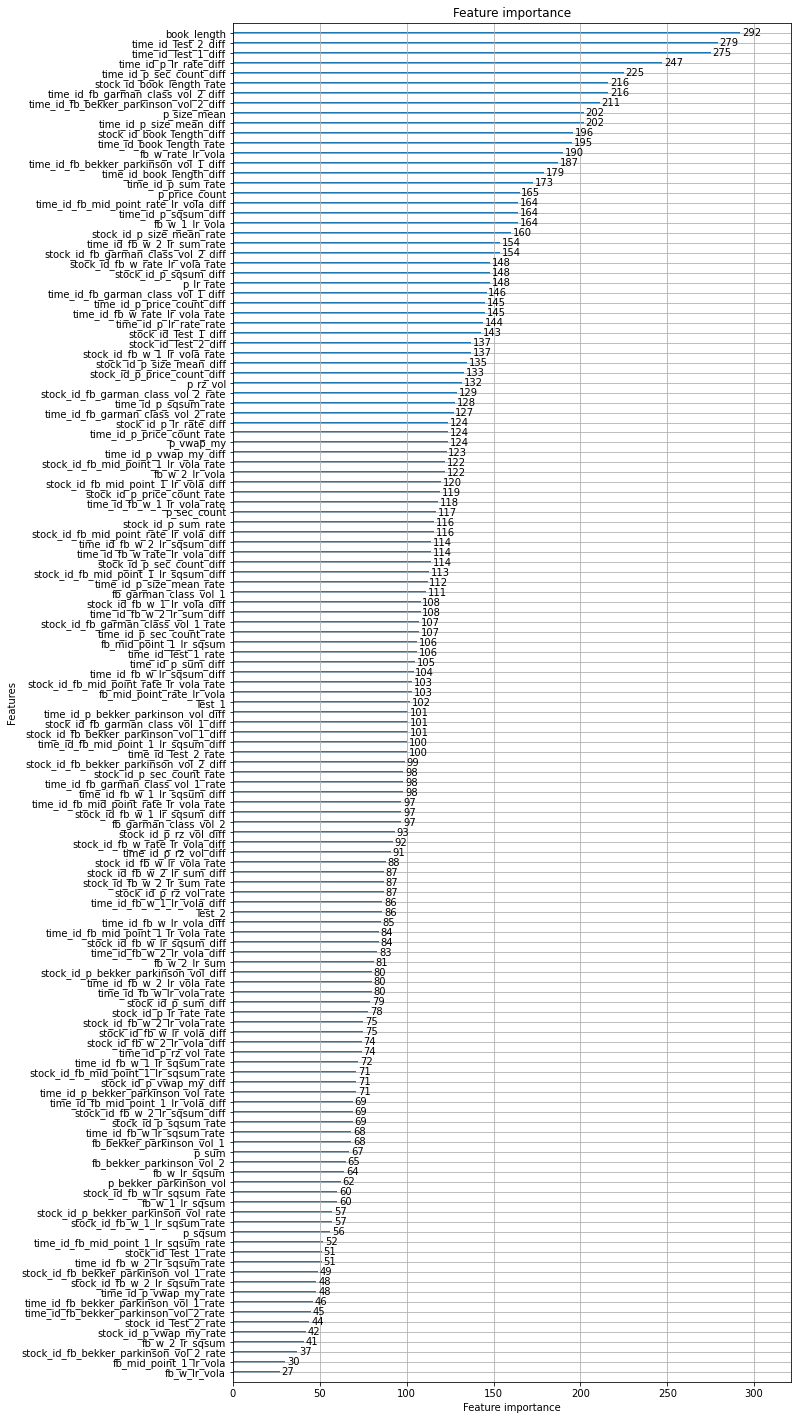

In [26]:
#models
for k,v in models.items():
    print(f"{k} - R2: {v['R2']} RMSPE: {v['RMSPE']}")
    lgbm.plot_importance(v['model'], figsize=(10,25), importance_type='split')

## SHAP Feature Importance

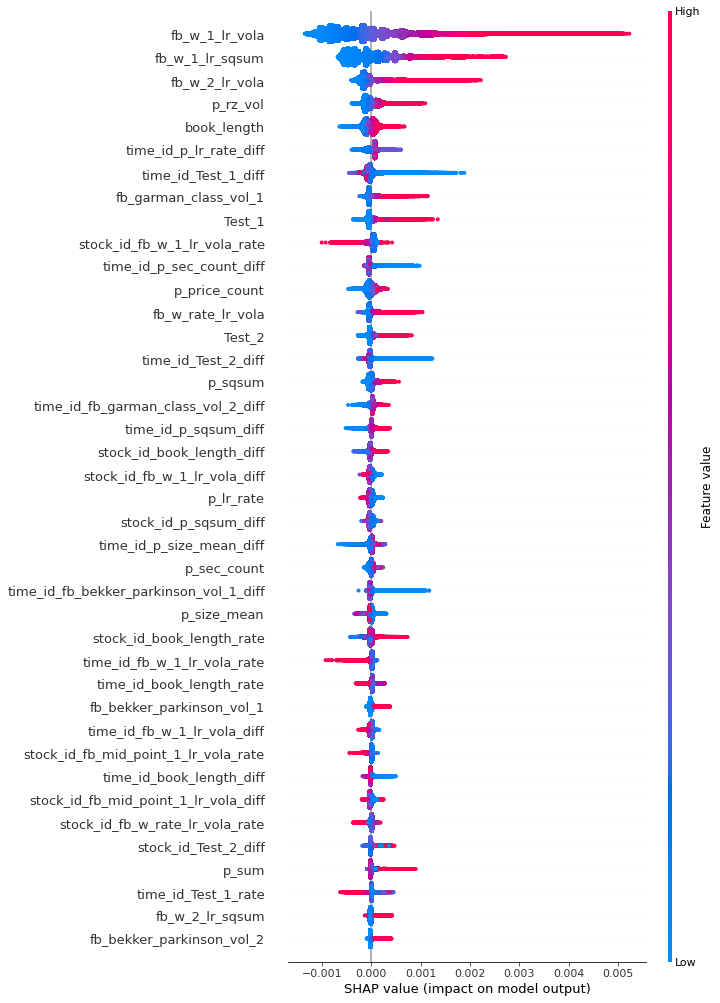

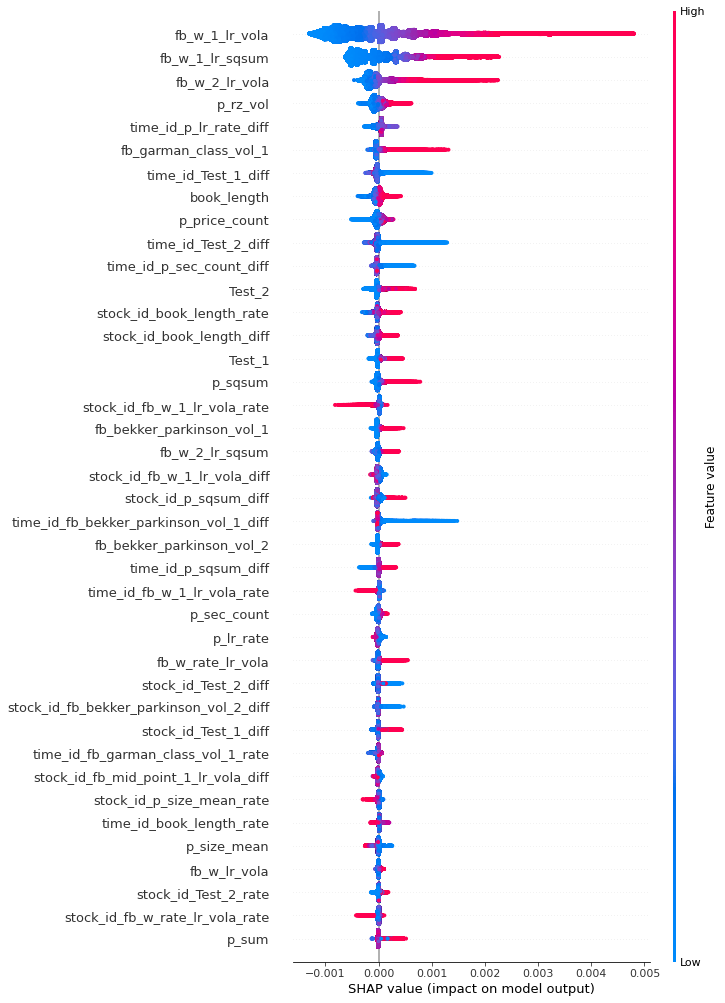

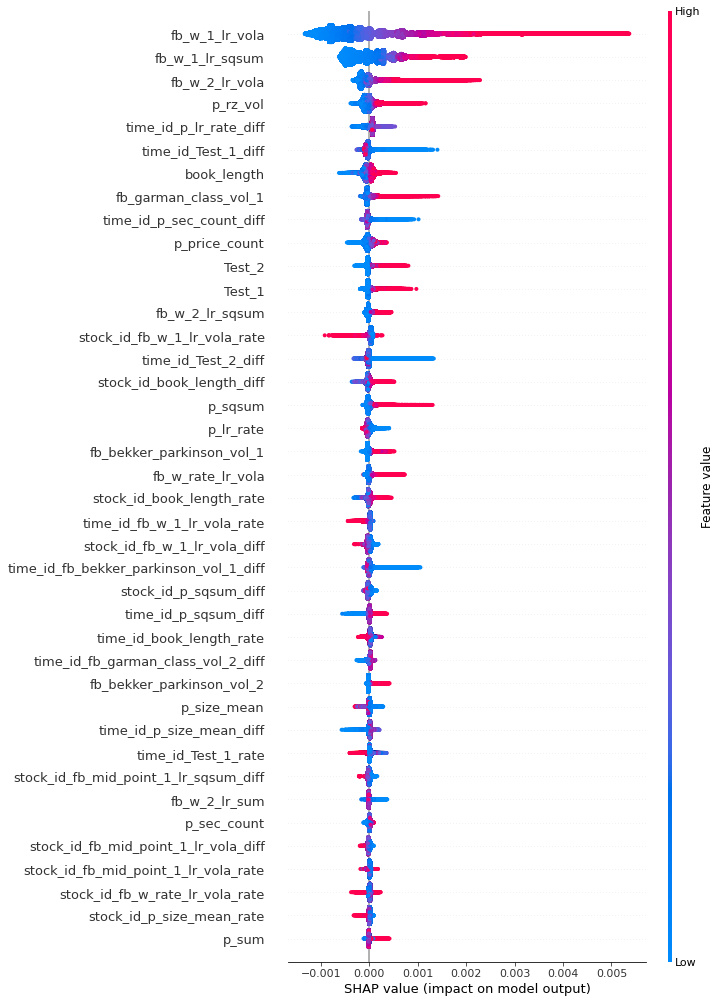

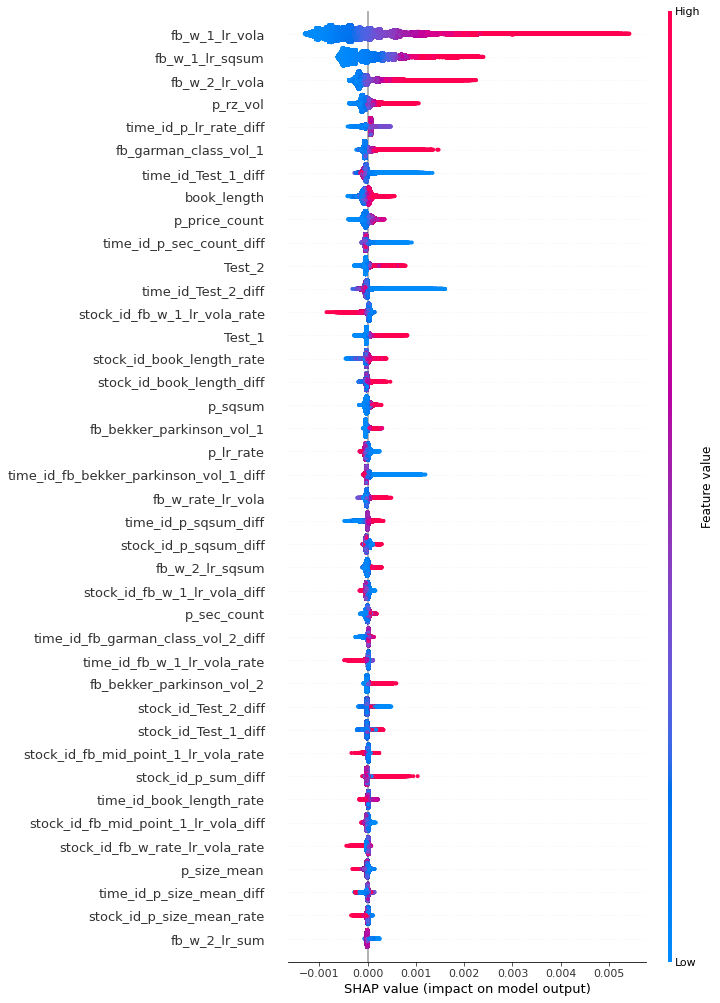

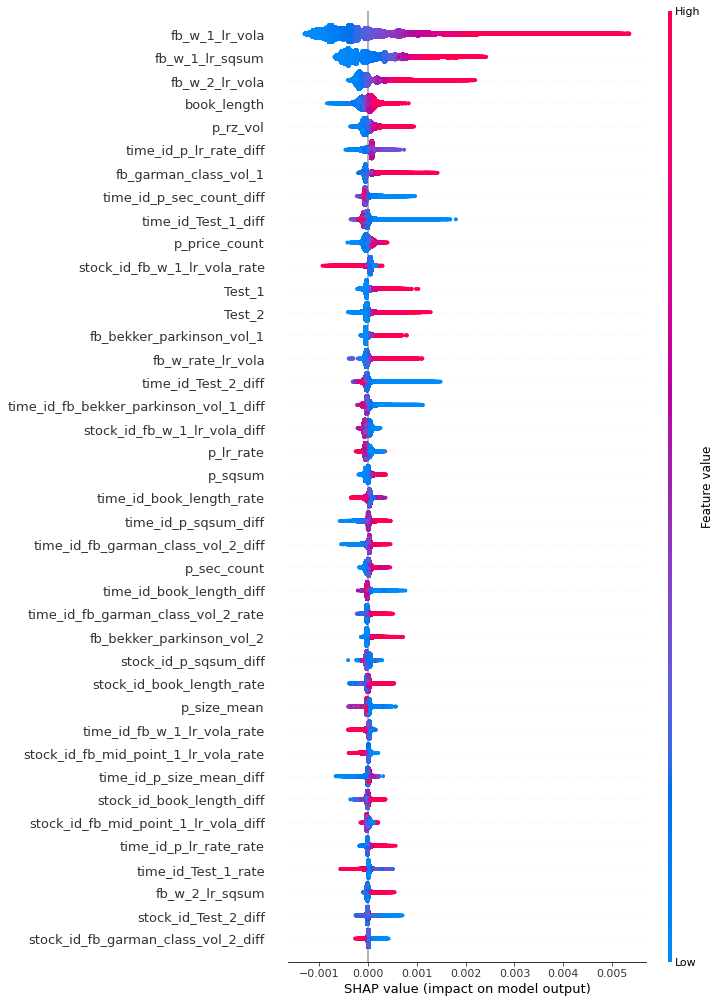

In [27]:
import shap

seeds=[42,456,555,333,444]
for (k,v),s in zip(models.items(), seeds):
    train_df, val_df, test_df = getTrainData(ret_df, seed=s)
    X_train = train_df.loc[:,used_cols]
    explainer = shap.TreeExplainer(v['model'])
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train, max_display=40)